In [2]:
from astropy.io import fits
from astropy.table import Table, Column, join
from tqdm import tqdm

# import DESI related modules - 
# from desispec.io import specprod_root
# from desitarget.targetmask import desi_mask
import fitsio
from astropy.io import fits


from dsigma.precompute import precompute
from dsigma.jackknife import compute_jackknife_fields, jackknife_resampling, compress_jackknife_fields
from dsigma.stacking import excess_surface_density,tangential_shear,lens_magnification_bias
from dsigma.surveys import des, kids, hsc

import pickle

import configparser

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/global/homes/s/sven/code/lensingWithoutBorders/')
from load_utils import precompute_and_stack

from tqdm import tqdm,trange

from copy import deepcopy

In [3]:
fpath_desi_lensing = "/global/cfs/cdirs/desicollab/science/c3/DESI-Lensing/"

In [4]:
fn_precomputed_cat_l = fpath_desi_lensing + "lensing_measurements/v1.1/precomputed_tables/{}/deltasigma_{}_zmin_{:.1f}_zmax_{:.1f}_blindA_boost_True_l.fits"
fn_precomputed_cat_r = fpath_desi_lensing + "lensing_measurements/v1.1/precomputed_tables/{}/deltasigma_{}_zmin_{:.1f}_zmax_{:.1f}_blindA_boost_True_r.fits"
fn_precomputed_cat_meta = fpath_desi_lensing + "lensing_measurements/v1.1/precomputed_tables/{}/deltasigma_{}_zmin_{:.1f}_zmax_{:.1f}_blindA_boost_True_meta.pkl"

In [5]:
lens_bins = {"BGS_BRIGHT":[0.1,0.2,0.3,0.4]}

galaxy_type = "BGS_BRIGHT"

lower_mass = ["10.56","11.0","11.33"]
upper_mass = [12.1,12.2,12.3]

In [6]:
def get_tables(lensing_survey,lens_bin,verbose=False):
    precomputed_table_l = Table.read(fn_precomputed_cat_l.format(lensing_survey, galaxy_type, lens_bins[galaxy_type][lens_bin], lens_bins[galaxy_type][lens_bin+1]))
    precomputed_table_r = Table.read(fn_precomputed_cat_r.format(lensing_survey, galaxy_type, lens_bins[galaxy_type][lens_bin], lens_bins[galaxy_type][lens_bin+1]))
    precomputed_meta = pickle.load(open(fn_precomputed_cat_meta.format(lensing_survey, galaxy_type, lens_bins[galaxy_type][lens_bin], lens_bins[galaxy_type][lens_bin+1]), "rb"))

    mstar_complete_cat = Table(fitsio.read(fpath_desi_lensing + f"desi_catalogues/matt_cat/{galaxy_type}_fastspec_lens_{lower_mass[lens_bin]}_{lens_bins[galaxy_type][lens_bin]:.1f}_{lens_bins[galaxy_type][lens_bin+1]:.1f}.dat.fits",
                                        columns=["TARGETID","LOGMSTAR"]))
    mmax = np.max(mstar_complete_cat["LOGMSTAR"])

    len_before = len(precomputed_table_l)
    len_mstar = len(mstar_complete_cat)
    precomputed_table_l = join(precomputed_table_l, mstar_complete_cat, keys="TARGETID", join_type="inner")
    precomputed_table_l.meta = precomputed_meta
    precomputed_table_r.meta = precomputed_meta


    if(verbose):
        print(f"Number of galaxies before: {len_before}, after: {len(precomputed_table_l)}")
        print(f"Maximum mass: {mmax}")

    return precomputed_table_l, precomputed_table_r

In [7]:
def get_stacking_kwargs(lensing_survey):
    config = configparser.ConfigParser()
    config.read("/global/homes/s/sven/code/lensingWithoutBorders/config_files/config_deltasigma_DESI_BGS.ini")

    survey = lensing_survey

    stacking_kwargs = {
        'photo_z_dilution_correction':config.getboolean(f'{survey.lower()}','photo_z_dilution_correction'),
        'boost_correction':config.getboolean(f'{survey.lower()}','boost_correction'),
        'scalar_shear_response_correction':config.getboolean(f'{survey.lower()}','scalar_shear_response_correction'),
        'matrix_shear_response_correction':config.getboolean(f'{survey.lower()}','matrix_shear_response_correction'),
        'shear_responsivity_correction':config.getboolean(f'{survey.lower()}','shear_responsivity_correction'),
        'hsc_selection_bias_correction':config.getboolean(f'{survey.lower()}','hsc_selection_bias_correction'),
        'random_subtraction':config.getboolean(f'{survey.lower()}','random_subtraction'),
        }

    return stacking_kwargs



1
2
3


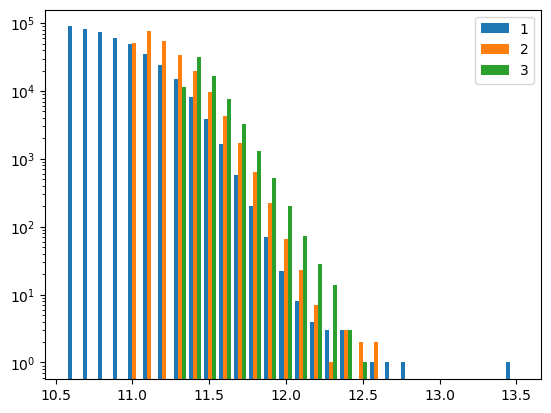

In [8]:
mstar_complete_cats = []
for lens_bin in range(3):
    tab = Table(fitsio.read(fpath_desi_lensing + f"desi_catalogues/matt_cat/{galaxy_type}_fastspec_lens_{lower_mass[lens_bin]}_{lens_bins[galaxy_type][lens_bin]:.1f}_{lens_bins[galaxy_type][lens_bin+1]:.1f}.dat.fits",
                                        columns=["TARGETID","LOGMSTAR"]))
    mstar_complete_cats.append(np.array(tab["LOGMSTAR"]))
    print(len(mstar_complete_cats))
plt.hist(mstar_complete_cats,bins=30,label=[1,2,3])
plt.legend()
plt.yscale('log')


In [9]:
results = {}
covariances = {}

for lensing_survey in ["DES","HSC","KiDS","SDSS"]:
    results[lensing_survey] = {}
    covariances[lensing_survey] = {}
    for lens_bin in trange(len(lens_bins[galaxy_type])-1,desc=lensing_survey):
        results[lensing_survey][lens_bin] = {}
        covariances[lensing_survey][lens_bin] = {}

        precomputed_table_l, precomputed_table_r = get_tables(lensing_survey,lens_bin)

        mmax = upper_mass[lens_bin]
        stacking_kwargs = get_stacking_kwargs(lensing_survey)
        mass_bins = np.geomspace(float(lower_mass[lens_bin]),mmax,4)
        mass_bins[-1] = 16
        for mass_bin in trange(len(mass_bins)-1,desc=str(lens_bin),leave=False):
            mask = (precomputed_table_l["LOGMSTAR"] > mass_bins[mass_bin]) & (precomputed_table_l["LOGMSTAR"] < mass_bins[mass_bin+1])
            print("Computing for ",np.sum(mask),"galaxies between ")
            result,covariance_matrix,_,_ = precompute_and_stack("deltasigma",deepcopy(precomputed_table_l[mask]),deepcopy(precomputed_table_r),
                                                                None,np.geomspace(0.08,80,16),None,
                                                                6,True,None,stacking_kwargs,None)
            results[lensing_survey][lens_bin][mass_bin] = result
            covariances[lensing_survey][lens_bin][mass_bin] = covariance_matrix

DES:   0%|          | 0/3 [00:00<?, ?it/s]

Computing for  25790 galaxies between 
**************************************************
The number of jackknife regions cannot be smaller than the number of continous fields. Try increasing `distance_threshold` or decreasing `centers`.
25790 6
Data jackknife fields could not be computed. Increasing distance threshold.
**************************************************


Computing for  7139 galaxies between 
**************************************************
The number of jackknife regions cannot be smaller than the number of continous fields. Try increasing `distance_threshold` or decreasing `centers`.
7139 6
Data jackknife fields could not be computed. Increasing distance threshold.
**************************************************


Computing for  222 galaxies between 


DES:  33%|███▎      | 1/3 [01:01<02:03, 61.87s/it]

Computing for  17224 galaxies between 
**************************************************
The number of jackknife regions cannot be smaller than the number of continous fields. Try increasing `distance_threshold` or decreasing `centers`.
17224 6
Data jackknife fields could not be computed. Increasing distance threshold.
**************************************************


Computing for  2376 galaxies between 
**************************************************
The number of jackknife regions cannot be smaller than the number of continous fields. Try increasing `distance_threshold` or decreasing `centers`.
2376 6
Data jackknife fields could not be computed. Increasing distance threshold.
**************************************************


Computing for  64 galaxies between 


DES:  33%|███▎      | 1/3 [01:50<03:40, 110.23s/it]


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

In [ ]:
fig,ax = plt.subplots(3,3,figsize=(15,15),sharex=True,sharey="row")
for lens_bin in range(len(lens_bins[galaxy_type])-1):
    for ls,lensing_survey in enumerate(["DES","HSC","KiDS","SDSS"]):
        for mass_bin in range(len(mass_bins)-1):
            result = results[lensing_survey][lens_bin][mass_bin]
            covariance = covariances[lensing_survey][lens_bin][mass_bin]
            ax[lens_bin,mass_bin].errorbar(result['rp']*1.1**ls,result['rp']*result['ds'],yerr=result['rp']*np.sqrt(np.diag(covariance)),
                                  label=lensing_survey,fmt="o",color=f"C{ls}")
            # ax[lens_bin,mass_bin].set_xscale("log")
            ax[lens_bin,mass_bin].set_yscale("log")
            ax[lens_bin,mass_bin].set_title(f"lens bin {lens_bin+1}, mass bin {mass_bin+1}")
            ax[lens_bin,mass_bin].legend()
ax[0,0].set_xscale('log')